In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('heart.csv')

## Getting some insight about our data

In [3]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
df.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6f9a47f390>,
      dtype=object)

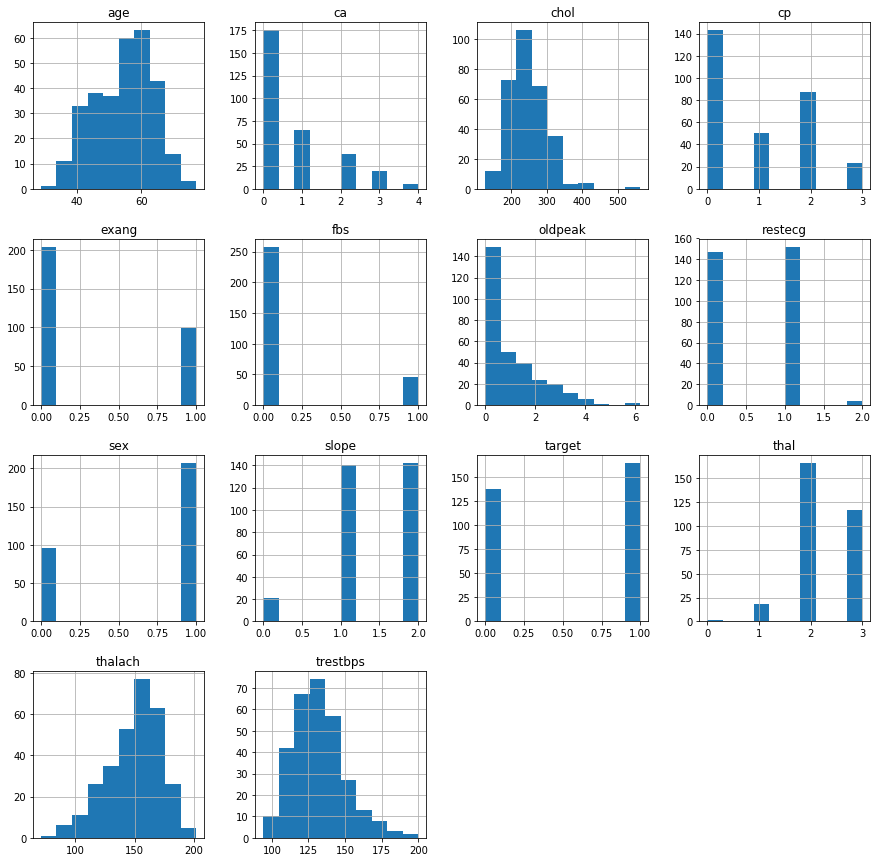

In [5]:
df.hist(figsize=(15,15))

We can see that the dataset contains few categorical features and few continuous features

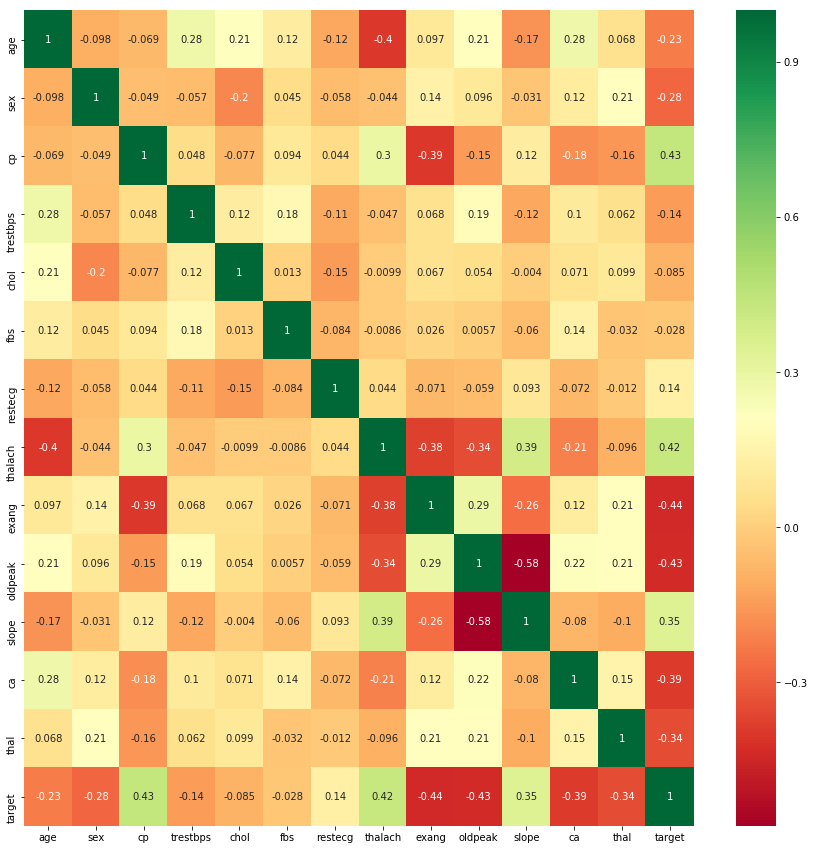

In [6]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(),annot=True,cmap='RdYlGn')

There are few features that have negative correlation with target and few with positive correlation

No disease:46.0%
Disease:54.0%


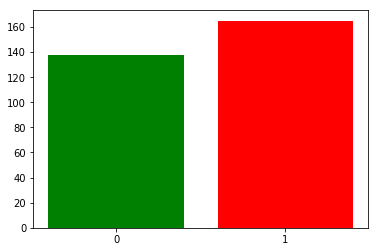

In [7]:
plt.bar(df.target.unique(),df.target.value_counts(),color=['red','green'])
plt.xticks([0,1])
print('No disease:{}%\nDisease:{}%'.format(round(df.target.value_counts(normalize=True)[0],2)*100,
                                           round(df.target.value_counts(normalize=True)[1],2)*100))

The two classes are not exactly 50% each but the ratio is good enough to continue without dropping/increasing our data.

## Data Preprocessing

In [8]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
column_trans = make_column_transformer(
                (OneHotEncoder(),['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']),
                (StandardScaler(),['age', 'trestbps', 'chol', 'thalach', 'oldpeak']),
                remainder = 'passthrough')

Applying OneHotEncoder on the categorical features and StandardScalar on continuous features

## Train Test Split

In [9]:
from sklearn.model_selection import train_test_split
X = df.drop(['target'], axis = 1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0)

In [10]:
column_trans.fit_transform(X_train)

array([[ 1.        ,  0.        ,  1.        , ...,  0.82851175,
        -2.00163972,  0.66036428],
       [ 1.        ,  0.        ,  0.        , ...,  0.07503002,
         0.97945954, -0.91869649],
       [ 0.        ,  1.        ,  1.        , ...,  1.3308329 ,
        -1.8661352 ,  1.07590658],
       ...,
       [ 0.        ,  1.        ,  0.        , ..., -0.9834324 ,
         0.52777784,  0.66036428],
       [ 0.        ,  1.        ,  0.        , ...,  0.16473023,
         0.25676881, -0.91869649],
       [ 0.        ,  1.        ,  0.        , ...,  0.64911134,
         0.43744149,  0.57725581]])

## Classification Algorithms

### 1. Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
logreg = LogisticRegression(solver='lbfgs')
pipe = make_pipeline(column_trans,logreg)

In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy').mean()

0.8621951219512194

### 2. K Nearest Neighbors

In [13]:
from sklearn.neighbors import KNeighborsClassifier
knn_scores = []
for k in range(1,31):
    knn_classifier = KNeighborsClassifier(n_neighbors = k)
    pipe = make_pipeline(column_trans,knn_classifier)
    knn_scores.append(cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy').mean())

Text(0.5, 1.0, 'K Neighbors Classifier scores for different K values')

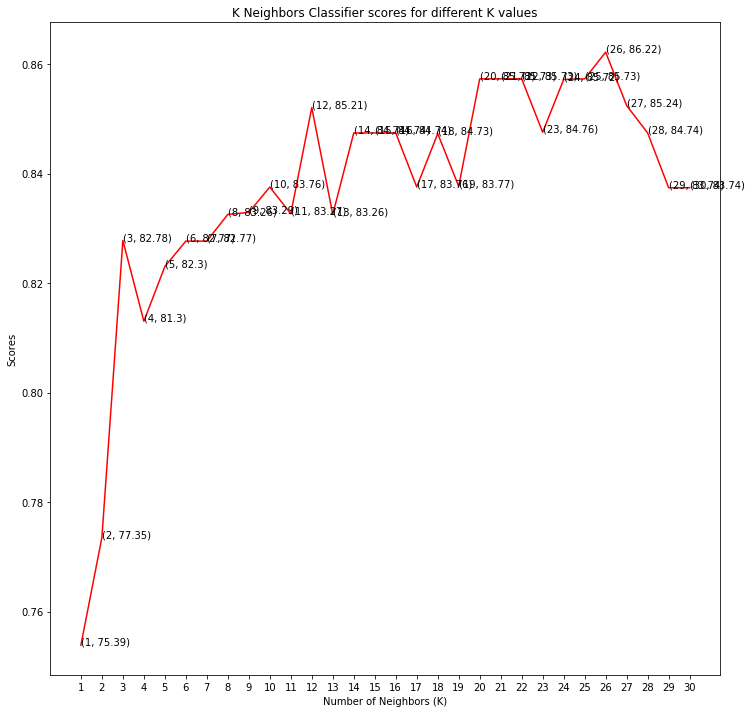

In [14]:
plt.figure(figsize=(12,12))
plt.plot([k for k in range(1, 31)], knn_scores, color = 'red')
for i in range(1,31):
    plt.text(i, knn_scores[i-1], (i, round(knn_scores[i-1]*100,2)))
plt.xticks([i for i in range(1, 31)])
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Scores')
plt.title('K Neighbors Classifier scores for different K values')

In [15]:
knn_scores[25]

0.8621951219512196

### 3. Support Vector Classifier (SVC)

There are several kernels for Support Vector Classifier. I'll test some of them and check which has the best score.

In [16]:
from sklearn.svm import SVC
svc_scores = []
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
for i in range(len(kernels)):
    svc_classifier = SVC(kernel = kernels[i])
    pipe = make_pipeline(column_trans,svc_classifier)
    svc_scores.append(cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy').mean())

Text(0.5, 1.0, 'Support Vector Classifier scores for different kernels')

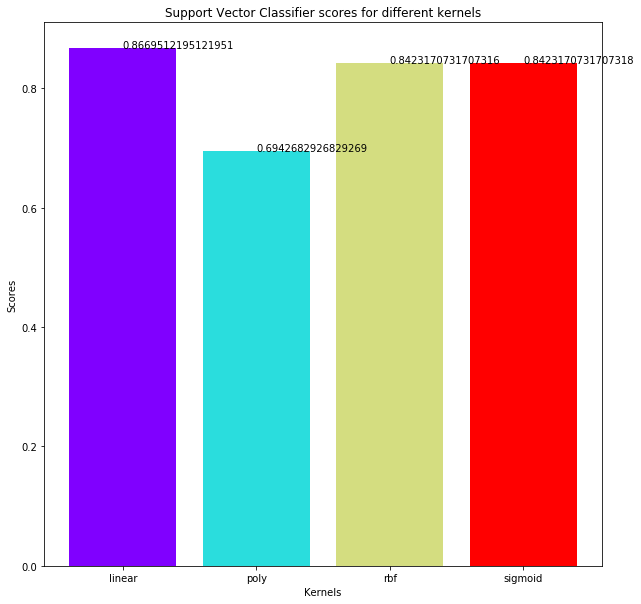

In [17]:
from matplotlib.cm import rainbow
colors = rainbow(np.linspace(0, 1, len(kernels)))
plt.figure(figsize=(10,10))
plt.bar(kernels, svc_scores, color = colors)
for i in range(len(kernels)):
    plt.text(i, svc_scores[i], svc_scores[i])
plt.xlabel('Kernels')
plt.ylabel('Scores')
plt.title('Support Vector Classifier scores for different kernels')

In [18]:
svc_scores[0] #linear

0.8669512195121951

### 4. Decision Tree Classifier

In [19]:
from sklearn.tree import DecisionTreeClassifier
dt_scores = []
for i in range(1, len(X.columns) + 1):
    dt_classifier = DecisionTreeClassifier(max_features = i, random_state = 0)
    pipe = make_pipeline(column_trans,dt_classifier)
    dt_scores.append(cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy').mean())

Text(0.5, 1.0, 'Decision Tree Classifier scores for different number of maximum features')

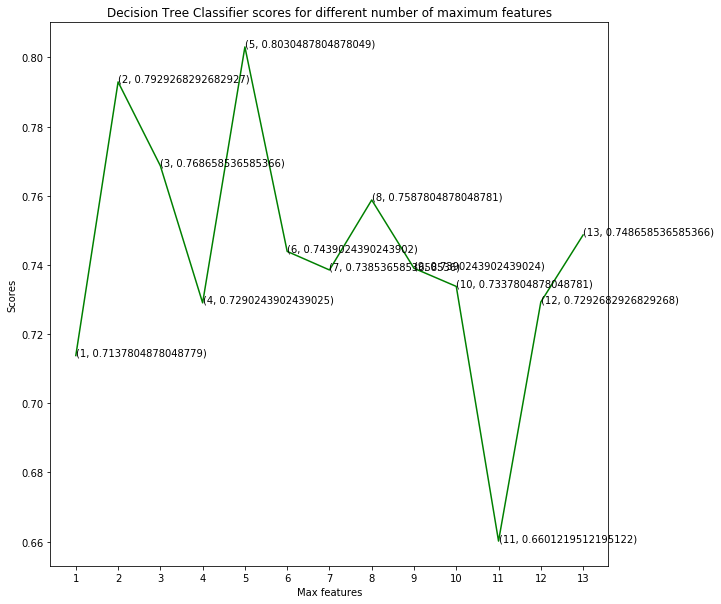

In [20]:
plt.figure(figsize=(10,10))
plt.plot([i for i in range(1, len(X.columns) + 1)], dt_scores, color = 'green')
for i in range(1, len(X.columns) + 1):
    plt.text(i, dt_scores[i-1], (i, dt_scores[i-1]))
plt.xticks([i for i in range(1, len(X.columns) + 1)])
plt.xlabel('Max features')
plt.ylabel('Scores')
plt.title('Decision Tree Classifier scores for different number of maximum features')

In [21]:
dt_scores[4]

0.8030487804878049

### 5. Random Forest Classifier

In [22]:
from sklearn.ensemble import RandomForestClassifier
rf_scores = []
estimators = [10, 100, 200, 500, 1000]
for i in estimators:
    rf_classifier = RandomForestClassifier(n_estimators = i, random_state = 0)
    pipe = make_pipeline(column_trans,rf_classifier)
    rf_scores.append(cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy').mean())

Text(0.5, 1.0, 'Random Forest Classifier scores for different number of estimators')

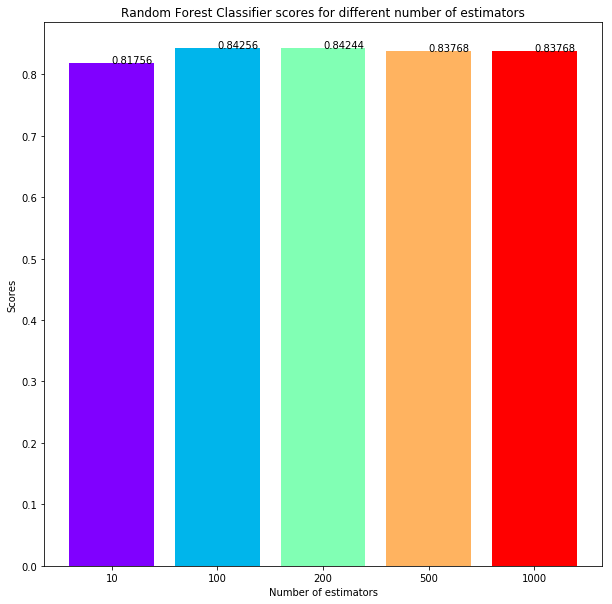

In [23]:
plt.figure(figsize=(10,10))
colors = rainbow(np.linspace(0, 1, len(estimators)))
plt.bar([i for i in range(len(estimators))], rf_scores, color = colors, width = 0.8)
for i in range(len(estimators)):
    plt.text(i, rf_scores[i], round(rf_scores[i],5))
plt.xticks(ticks = [i for i in range(len(estimators))], labels = [str(estimator) for estimator in estimators])
plt.xlabel('Number of estimators')
plt.ylabel('Scores')
plt.title('Random Forest Classifier scores for different number of estimators')

In [24]:
rf_scores[1]

0.8425609756097561

### 6. Gaussian NB

In [25]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
pipe = make_pipeline(column_trans,nb)
cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy').mean()

0.8082926829268293

It is worth to test our data on 'testing dataset' using two classification models that are having high accuracy score than other classification models. They are (i) Logistic Regression and (ii) SVC using linear kernel.

## Make predictions on "unseen" data

### 1. Logistic Regression

In [26]:
pipe = make_pipeline(column_trans,logreg)
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('columntransformer', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('onehotencoder', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='error...enalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])

In [27]:
y_pred = pipe.predict(X_test)

In [28]:
from sklearn import metrics
metrics.accuracy_score(y_test,y_pred)*100

84.0

### 2. SVC with linear kernel

In [29]:
svc_classifier = SVC(kernel = 'linear')
pipe = make_pipeline(column_trans,svc_classifier)
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('columntransformer', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('onehotencoder', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='error...r', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

In [30]:
y_pred = pipe.predict(X_test)

In [31]:
from sklearn import metrics
metrics.accuracy_score(y_test,y_pred)*100

83.0